## SELENIUM CODE

In [1]:
from collections import namedtuple
from time import sleep

from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from tqdm import tqdm

SEARCH_URL = "https://osf.io/preprints/discover?q=depression"
OSFPaperTuple = namedtuple("OSFPaperTuple", 
                           field_names=["PaperName","URL","LastEdited","Categories","Source"])

In [2]:
def get_page_html(url):
    """Shorthand for retrieving a page's HTML and processing it into BeautifulSoup."""
    return BeautifulSoup(requests.get(url).text, "lxml")


def download_pdf(pdf_url, file_destination):
    """Downloads a single PDF file from the given URL"""
    response = requests.get(pdf_url)
    with open(file_destination,'wb') as f:
        f.write(response.content)

In [ ]:
# set up the Selenium driver
driver = webdriver.Firefox()

In [3]:
driver.get(SEARCH_URL)
sleep(5)
page_html = BeautifulSoup(driver.page_source, "lxml")

In [7]:
pagination_element = page_html.find_all("ul", attrs={"class":"pagination"})[-1]
last_page_link = pagination_element.find_all("li", attrs={"class":"ember-view"})[-1]
number_of_pages = int(last_page_link.text.strip())

In [8]:
number_of_pages

443

### Places where information is located:
- Title & link: \<a\> element inside lone \<h4\> element
- Last edited date: lone \<em\> element
- Categories: text in \<span\> elements with class="subject-preview" (note: not all papers have categories
- Source: text in \<span\> element with class="search-result-providers"

In [1]:
def get_OSF_paper_info(paper_element):
    paper_link = paper_element.find("h4")
    if paper_link.a:
        paper_name = paper_link.a.text.strip()
        paper_url = paper_link.a["href"]
    else:
        paper_name = paper_link.span.text.strip()
        paper_url = ""
        
    last_edited = paper_element.find("em").text.strip()[13:-4]
    
    category_elements = paper_element.find_all("span", attrs={"class":"subject-preview"})
    if category_elements:
        categories = [e.text.strip() for e in category_elements]
    else:
        categories = []
    
    source_name = paper_element.find("span", attrs={"class":"search-result-providers"}).text.strip()
    return OSFPaperTuple(paper_name, paper_url, last_edited, categories, source_name)

In [10]:
paper_tuples = []
for page in tqdm(range(number_of_pages)):
    target_page = f"https://osf.io/preprints/discover?page={page+1}&q=depression"
    driver.get(target_page)
    sleep(5)  ## try to avoid overwhelming the site
    
    page_html = BeautifulSoup(driver.page_source, "lxml")
    papers_on_page = page_html.find_all("div", attrs={"class": "col-sm-8"})[1]
    paper_elements = papers_on_page.find_all("div", attrs={"class":"ember-view"}, recursive=False)
    current_page_tuples = [get_OSF_paper_info(p) for p in paper_elements]
    paper_tuples.extend(current_page_tuples)

100%|██████████| 443/443 [39:02<00:00,  5.29s/it]


In [13]:
paper_df = pd.DataFrame(paper_tuples)
paper_df.to_csv("OSF_paper_info.csv", index=False)

In [14]:
driver.close()

## ANALYSIS

### Part 1: Source counts

In [2]:
from collections import Counter
import re

import nltk
from nltk.stem.snowball import SnowballStemmer

In [3]:
stemmer = SnowballStemmer("english")
english_stopwords = set(nltk.corpus.stopwords.words("english"))

In [4]:
# note: I read this in later, so the Categories column is loaded
# as a string instead of a list; that's fixed later
paper_df = pd.read_csv("OSF_paper_info.csv")
len(paper_df)

4414

In [5]:
# there are duplicates, unfortunately
paper_df = paper_df[~paper_df.duplicated()]
len(paper_df)

3475

In [8]:
paper_df["Source"].value_counts()

RePEc             1625
PsyArXiv           696
arXiv              433
bioRxiv            297
Preprints.org      159
OSF Preprints      143
SocArXiv            38
PeerJ               28
MindRxiv            15
Thesis Commons       9
INA-Rxiv             9
SportRxiv            7
EarthArXiv           6
MetaArXiv            4
AfricArXiv           2
Cogprints            2
AgriXiv              1
NutriXiv             1
Name: Source, dtype: int64

In [28]:
import random
random.sample(paper_df[paper_df["Source"]=="OSF Preprints"]["PaperName"].tolist(), 6)

['Music and mood regulation during the early-stages of the COVID-19 pandemic',
 'High frequency stimulation-induced plasticity in the prelimbic cortex of rats emerges during adolescent development and is associated with an increase in dopamine receptor function',
 'Preprint BuckfieldSinclairGlautier (2019) Slow associative learning in alcohol dependence and the Alcohol Cue Exposure Treatment Paradox',
 'Subclinical anxiety and depression are associated with deficits in attentional target facilitation, not distractor inhibition',
 'Placebo response and psychosis: a putative shared mechanism',
 'Combat stress in a small-scale society suggest divergent evolutionary roots for posttraumatic stress disorder symptoms']

### Part 2: Most common stems

In [13]:
def title_list_to_stems(title_list, stemmer, stopwords):
    # note: gotta use .lower(), otherwise stopwords aren't properly caught
    word_list = [word for title in title_list for word in nltk.word_tokenize(title.lower())]
    word_list = [word for word in word_list if re.search("[a-z]", word)]
    word_list = [word for word in word_list if word not in stopwords]
    stems = [stemmer.stem(word) for word in word_list]
    return stems

In [12]:
num_most_common = 15
sources_with_enough_papers = ["RePEc", "PsyArXiv", "arXiv", "bioRxiv", "Preprints.org", "OSF Preprints"]

In [14]:
paper_stems_dict = {}
for s in sources_with_enough_papers:
    titles = paper_df[paper_df["Source"] == s]["PaperName"].tolist()
    stems = title_list_to_stems(titles, stemmer, english_stopwords)
    most_common_stems = Counter(stems).most_common(num_most_common)
    paper_stems_dict[s] = [m[0] for m in most_common_stems]

In [15]:
pd.DataFrame(paper_stems_dict)

,RePEc,PsyArXiv,arXiv,bioRxiv,Preprints.org,OSF Preprints
0,depress,depress,depress,depress,depress,depress
1,great,covid-19,effect,genet,health,health
2,financi,health,model,disord,mental,mental
3,econom,symptom,dynam,studi,effect,covid-19
4,crisi,mental,network,risk,among,symptom
5,polici,pandem,galaxi,associ,covid-19,studi
6,health,anxieti,synapt,effect,studi,review
7,bank,studi,magnet,major,disord,adolesc
8,evid,adolesc,star,brain,stress,disord
9,market,associ,use,analysi,patient,among


In [25]:
covid19_mentions = paper_df[paper_df["PaperName"].apply(lambda x: "covid" in x.lower())]
covid19_mentions["Source"].value_counts()

PsyArXiv         149
Preprints.org     21
OSF Preprints     19
SocArXiv          11
AfricArXiv         2
arXiv              1
Name: Source, dtype: int64

In [ ]:
AfricArXiv       1.000000
OSF Preprints    0.132867
Preprints.org    0.132075
PsyArXiv         0.214080
SocArXiv         0.289474
arXiv            0.002309
Name: Source, dtype: float64

### Part 3: Counts of Categories

In [26]:
paper_df["Categories"] = paper_df["Categories"].apply(eval)

In [27]:
(paper_df["Categories"].apply(lambda x: x == [])).mean()

0.6529496402877698

In [28]:
pd.crosstab(paper_df["Source"], paper_df["Categories"].apply(lambda x: x == []))

Categories,False,True
Source,,
AfricArXiv,2,0
AgriXiv,1,0
Cogprints,0,2
EarthArXiv,6,0
INA-Rxiv,9,0
MetaArXiv,4,0
MindRxiv,15,0
NutriXiv,1,0
OSF Preprints,143,0


In [29]:
Counter([x for y in paper_df["Categories"].tolist() for x in y]).most_common(20)

[('Social and Behavioral Sciences', 760),
 ('Psychology', 673),
 ('Clinical Psychology', 433),
 ('Medicine and Health Sciences', 376),
 ('Medical Specialties', 260),
 ('Psychiatry', 255),
 ('Life Sciences', 162),
 ('Health Psychology', 127),
 ('Biology', 126),
 ('Neuroscience and Neurobiology', 120),
 ('Psychiatry and Psychology', 103),
 ('Child Psychology', 85),
 ('Personality and Social Contexts', 78),
 ('Cognitive Psychology', 77),
 ('Physics', 75),
 ('Quantitative Psychology', 66),
 ('Mental Disorders', 59),
 ('Social Psychology', 56),
 ('Developmental Psychology', 45),
 ('Counseling Psychology', 38)]

### Part 4: Year counts

In [10]:
paper_df["LastEdited"] = pd.to_datetime(paper_df["LastEdited"])
paper_df["Year"] = paper_df["LastEdited"].dt.year
paper_df["Year"].value_counts().sort_index()

2007     40
2008     16
2009     82
2010     11
2011     22
2012     31
2013    176
2014    458
2015    488
2016    638
2017    258
2018    309
2019    138
2020    441
2021    367
Name: Year, dtype: int64

In [17]:
papers_with_good_sources = paper_df[paper_df["Source"].isin(sources_with_enough_papers)]
pd.crosstab(papers_with_good_sources["Year"], papers_with_good_sources["Source"])

Source,OSF Preprints,Preprints.org,PsyArXiv,RePEc,arXiv,bioRxiv
Year,,,,,,
2007,0,0,0,0,40,0
2008,0,0,0,0,16,0
2009,0,0,0,0,82,0
2010,0,0,0,0,11,0
2011,0,0,0,0,22,0
2012,0,0,0,0,31,0
2013,0,0,0,156,19,0
2014,0,0,0,412,30,5
2015,0,0,0,381,90,7


In [ ]:
## stacked bar chart of year, normalized to 1, colored by sources

<AxesSubplot:xlabel='Year', ylabel='Count'>

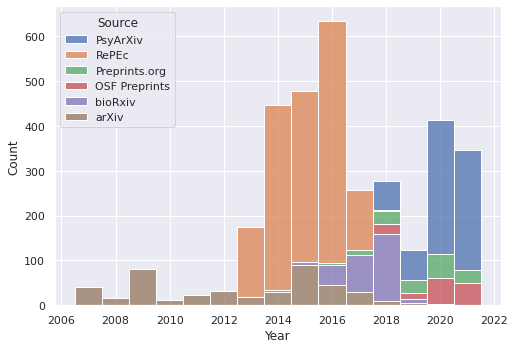

In [39]:
import seaborn as sns
sns.set(rc={"figure.figsize": (8,5.5)})
sns.histplot(papers_with_good_sources, x="Year", hue="Source",
             multiple="stack", discrete=True)

In [34]:
?sns.histplot